## Surfing Maneuver Recognition using S3D Transfer Learning
---


This notebook demonstrates transfer learning for video-based surfing maneuver recognition using the **S3D (Separable 3D CNN)** model.

**Dataset**: Surf Maneuver Recognition Dataset

The dataset contains video clips of surfers performing four different maneuvers:
1. **Cutback-Frontside**: A sharp turn back towards the breaking part of the wave
2. **Take-off**: The act of catching the wave and standing up on the surfboard
3. **360**: A full rotation maneuver while on the wave
4. **Roller**: Riding on top of the breaking wave

**Model**: [S3D](https://arxiv.org/abs/1712.04851) (Separable 3D CNN) is an efficient video recognition model that uses depthwise separable convolutions to reduce computational cost while maintaining accuracy. It's based on the Inception architecture adapted for video understanding.

**Approach**: We'll use transfer learning by loading S3D pretrained on Kinetics-400 (a large action recognition dataset with 400 classes) and fine-tune it for our surfing maneuver classification task.


### Import Libraries


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.models.video import s3d, S3D_Weights
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
import os
from pathlib import Path
import cv2
import numpy as np
import random


### Class Names


In [2]:
class_names = [
    'cutback-frontside',
    'take-off',
    '360',
    'roller'
]


### Class Distribution Analysis

Let's analyze the distribution of classes in our training and validation sets to check for class imbalance.


CLASS DISTRIBUTION ANALYSIS

Class                Train      Val        Test       Total     
----------------------------------------------------------------------
cutback-frontside    166        25         47         238       
take-off             84         13         24         121       
360                  125        19         36         180       
roller               366        53         104        523       
----------------------------------------------------------------------
TOTAL                741        110        211        1062      

TRAINING SET - CLASS BALANCE
cutback-frontside   :  166 samples ( 22.4%)
take-off            :   84 samples ( 11.3%)
360                 :  125 samples ( 16.9%)
roller              :  366 samples ( 49.4%)

Imbalance Ratio (max/min): 4.36 : 1


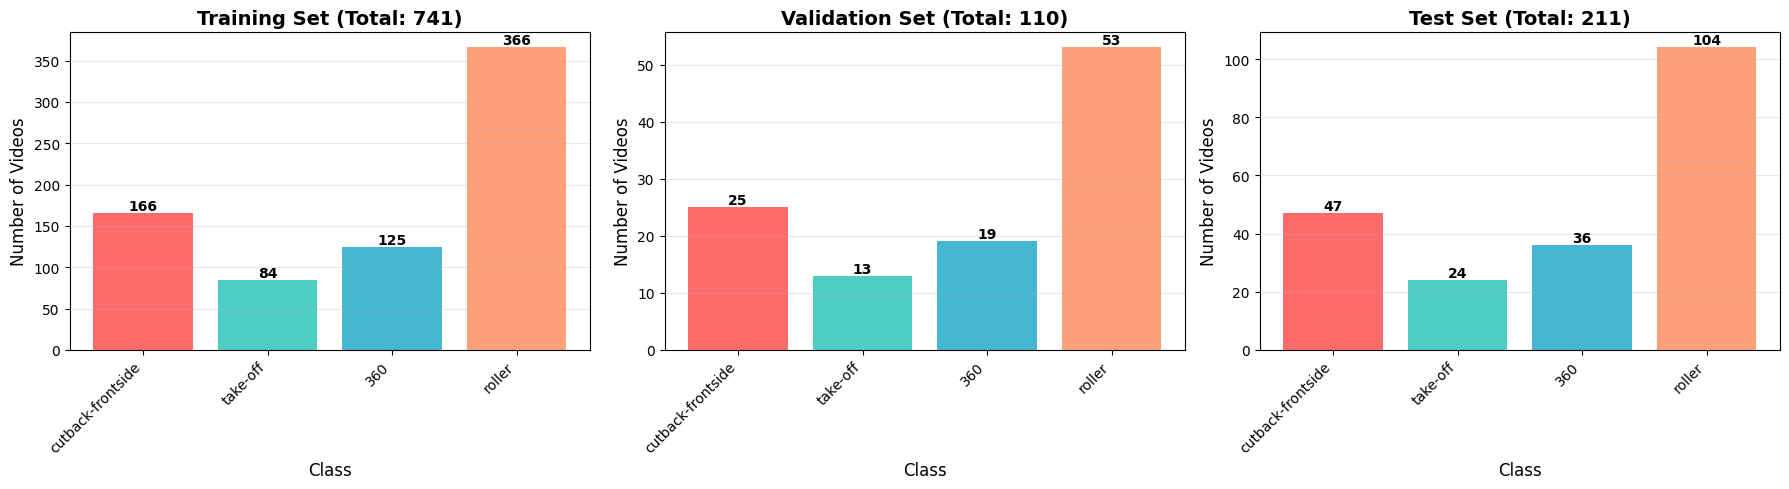

In [3]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

def count_videos_per_class(data_dir, class_names):
    """Count number of videos in each class."""
    data_dir = Path(data_dir)
    video_extensions = ['.mp4', '.avi', '.mov', '.mkv', '.MP4', '.AVI', '.MOV', '.MKV']
    
    counts = {}
    for class_name in class_names:
        class_dir = data_dir / class_name
        if class_dir.exists():
            count = sum(1 for f in class_dir.iterdir() if f.suffix in video_extensions)
            counts[class_name] = count
        else:
            counts[class_name] = 0
    
    return counts

# Count videos in each split
train_counts = count_videos_per_class('./surfing_dataset/train', class_names)
val_counts = count_videos_per_class('./surfing_dataset/val', class_names)
test_counts = count_videos_per_class('./surfing_dataset/test', class_names)

# Display the counts
print("=" * 70)
print("CLASS DISTRIBUTION ANALYSIS")
print("=" * 70)
print(f"\n{'Class':<20} {'Train':<10} {'Val':<10} {'Test':<10} {'Total':<10}")
print("-" * 70)

total_train = 0
total_val = 0
total_test = 0

for class_name in class_names:
    train_c = train_counts[class_name]
    val_c = val_counts[class_name]
    test_c = test_counts[class_name]
    total_c = train_c + val_c + test_c
    
    total_train += train_c
    total_val += val_c
    total_test += test_c
    
    print(f"{class_name:<20} {train_c:<10} {val_c:<10} {test_c:<10} {total_c:<10}")

print("-" * 70)
print(f"{'TOTAL':<20} {total_train:<10} {total_val:<10} {total_test:<10} {total_train + total_val + total_test:<10}")

# Calculate class percentages for training set
print("\n" + "=" * 70)
print("TRAINING SET - CLASS BALANCE")
print("=" * 70)
for class_name in class_names:
    percentage = (train_counts[class_name] / total_train) * 100
    print(f"{class_name:<20}: {train_counts[class_name]:>4} samples ({percentage:>5.1f}%)")

# Calculate imbalance ratio
max_count = max(train_counts.values())
min_count = min(train_counts.values())
imbalance_ratio = max_count / min_count
print(f"\nImbalance Ratio (max/min): {imbalance_ratio:.2f} : 1")

if imbalance_ratio > 2.0:
    print("WARNING: Significant class imbalance detected!")
else:
    print("Classes are reasonably balanced")

# Visualize the distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

splits = ['Training', 'Validation', 'Test']
counts_list = [train_counts, val_counts, test_counts]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

for idx, (split, counts) in enumerate(zip(splits, counts_list)):
    ax = axes[idx]
    classes = list(counts.keys())
    values = list(counts.values())
    
    bars = ax.bar(range(len(classes)), values, color=colors)
    ax.set_xlabel('Class', fontsize=12)
    ax.set_ylabel('Number of Videos', fontsize=12)
    ax.set_title(f'{split} Set (Total: {sum(values)})', fontsize=14, fontweight='bold')
    ax.set_xticks(range(len(classes)))
    ax.set_xticklabels(classes, rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(value)}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


### Device Configuration

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("mps" if torch.mps.is_available() else "cpu")  # For Mac M1/M2
print(f"Using device: {device}")


Using device: cuda


### Hyperparameters


In [5]:
BATCH_SIZE = 6
EPOCHS = 25
NUM_FRAMES = 64  # S3D typically uses 64 frames (can be adjusted)
FRAME_SIZE = 224  # S3D input size (for reference - official transforms handle resizing)
LEARNING_RATE = 0.0007921156893750506
DROPOUT_RATE = 0.0035983097734904046
WEIGHT_DECAY = 0.0005284384205738847
NUM_CLASSES = 4  # Cutback-Frontside, Take-off, 360, Roller


# criterion = nn.CrossEntropyLoss()

# Adding weights
counts = torch.tensor([166, 84, 125, 366], dtype=torch.float32)  # [cutback-frontside, take-off, 360, roller]
weights = torch.sqrt(1.0 / counts)
weights = weights / weights.sum() * len(counts)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))  

# Set all random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Make training deterministic (may impact performance slightly)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Create generator for DataLoader
dataloader_generator = torch.Generator()
dataloader_generator.manual_seed(SEED)


In [6]:
class CachedSurfingManeuverDataset(Dataset):
    """
    Fast dataset that loads pre-cached video tensors.
    
    Videos should be preprocessed using preprocess_videos_cache.py first.
    This provides 10-20x faster data loading compared to on-the-fly preprocessing.
    """
    
    def __init__(self, cache_dir):
        self.cache_dir = Path(cache_dir)
        
        # Get all cached .pt files
        self.cache_files = []
        self.labels = []
        
        for class_idx, class_name in enumerate(class_names):
            class_cache_dir = self.cache_dir / class_name
            if class_cache_dir.exists():
                pt_files = list(class_cache_dir.glob('*.pt'))
                self.cache_files.extend(pt_files)
                self.labels.extend([class_idx] * len(pt_files))
        
        print(f"Found {len(self.cache_files)} cached videos across {len(class_names)} classes")
        
        if len(self.cache_files) == 0:
            print(f"\n WARNING: No cached files found in {cache_dir}")
            print(f"Please run 'python preprocess_videos_cache.py' first to create the cache.")
    
    def __len__(self):
        return len(self.cache_files)
    
    def __getitem__(self, idx):
        """Load a preprocessed video tensor from cache."""
        cache_file = self.cache_files[idx]
        
        try:
            # Load cached data (already preprocessed!)
            data = torch.load(cache_file, map_location='cpu')
            video = data['video']
            label = data['label']
            
            return video, label
            
        except Exception as e:
            print(f"Error loading cached file {cache_file}: {e}")
            # Return a random valid sample instead
            return self.__getitem__((idx + 1) % len(self))


### Data Transforms

S3D expects inputs with specific normalization (from Kinetics-400 pretraining).


In [7]:
# S3D preprocessing - using manual transforms since official ones have format issues
from torchvision.models.video import S3D_Weights
import torchvision.transforms.functional as F

# Normalization values from S3D Kinetics-400 pretraining
MEAN = [0.43216, 0.394666, 0.37645]
STD = [0.22803, 0.22145, 0.216989]

def video_transform(video):
    """
    Transform video from [T, H, W, C] uint8 to [C, T, H, W] float32 normalized.
    
    Args:
        video: torch.Tensor of shape [T, H, W, C] with uint8 values [0, 255]
    
    Returns:
        Processed video tensor [C, T, H, W] ready for S3D model
    """
    # Convert from [T, H, W, C] to [C, T, H, W]
    video = video.permute(3, 0, 1, 2)  # [T, H, W, C] -> [C, T, H, W]
    
    # Convert to float and scale to [0, 1]
    video = video.float() / 255.0
    
    # Resize each frame to 256x256 then center crop to 224x224
    # Process frame by frame to handle the temporal dimension correctly
    T = video.shape[1]
    resized_frames = []
    for t in range(T):
        frame = video[:, t, :, :]  # [C, H, W]
        # Resize to 256x256
        frame = F.resize(frame, [256, 256], antialias=True)
        # Center crop to 224x224
        frame = F.center_crop(frame, [224, 224])
        resized_frames.append(frame)
    
    # Stack back to [C, T, H, W]
    video = torch.stack(resized_frames, dim=1)
    
    # Normalize with S3D mean and std
    mean = torch.tensor(MEAN).view(3, 1, 1, 1)
    std = torch.tensor(STD).view(3, 1, 1, 1)
    video = (video - mean) / std
    
    return video

train_transform = video_transform
val_transform = video_transform


### Load Dataset

Preprocess the videos:
```bash
python preprocess_videos_cache.py
```

This will create `surfing_dataset_cache/` which:
- Sample frames uniformly
- Apply transformations
- Convert to the format expected by S3D (C, T, H, W)



In [8]:
# Cached dataset paths
CACHE_TRAIN_DIR = './surfing_dataset_cache/train'
CACHE_VAL_DIR = './surfing_dataset_cache/val'
CACHE_TEST_DIR = './surfing_dataset_cache/test'

# Load cached datasets
train_dataset = CachedSurfingManeuverDataset(cache_dir=CACHE_TRAIN_DIR)
val_dataset = CachedSurfingManeuverDataset(cache_dir=CACHE_VAL_DIR)
test_dataset = CachedSurfingManeuverDataset(cache_dir=CACHE_TEST_DIR)

# Create WeightedRandomSampler for balanced training
from torch.utils.data import WeightedRandomSampler

class_sample_counts = [166, 84, 125, 366]  # [cutback-frontside, take-off, 360, roller]
sample_weights = []

for idx in range(len(train_dataset)):
    label = train_dataset.labels[idx]
    sample_weights.append(1.0 / class_sample_counts[label])

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(train_dataset),
    replacement=True
)

print(f"\n{'='*70}")
print("WEIGHTED RANDOM SAMPLER")
print(f"{'='*70}")
print(f"Total samples: {len(sample_weights)}")
print(f"Sample weights range: [{min(sample_weights):.6f}, {max(sample_weights):.6f}]")
print("This ensures balanced sampling across all classes during training.")
print(f"{'='*70}\n")

# Create DataLoaders (no transform needed - videos are already preprocessed!)
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,  # Use sampler instead of shuffle=True
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")
print("✓ Using CACHED dataset - Fast data loading enabled!")
print("✓ Using WeightedRandomSampler for balanced class sampling!")


Found 741 cached videos across 4 classes
Found 110 cached videos across 4 classes
Found 211 cached videos across 4 classes

WEIGHTED RANDOM SAMPLER
Total samples: 741
Sample weights range: [0.002732, 0.011905]
This ensures balanced sampling across all classes during training.

Training set size: 741
Validation set size: 110
Test set size: 211
✓ Using CACHED dataset - Fast data loading enabled!
✓ Using WeightedRandomSampler for balanced class sampling!


### Visualize Sample Videos

Let's visualize a few frames from sample videos in the training set.


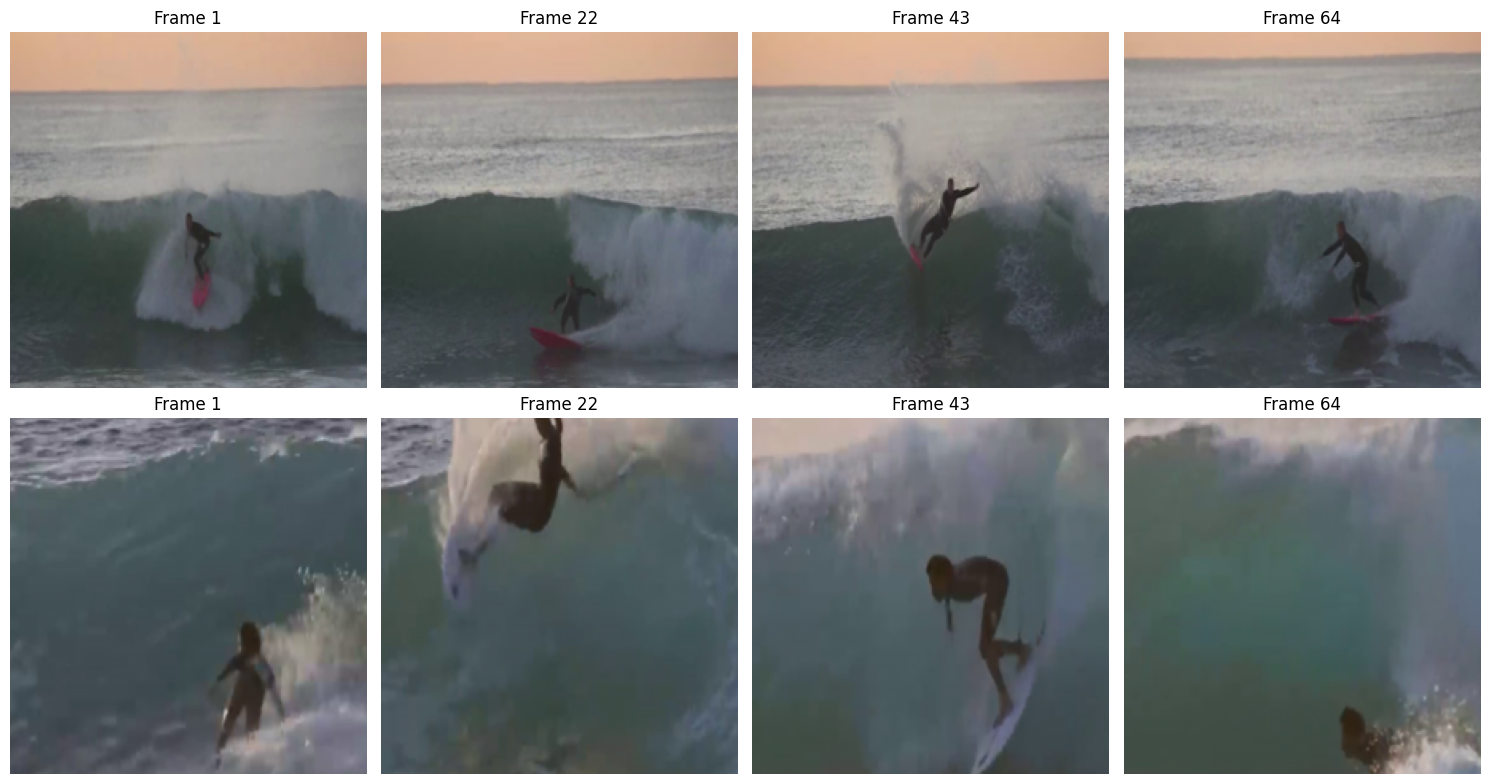

In [9]:
def plot_video_frames(dataloader, classes, n_videos=2, n_frames=4):
    """
    Plot sample frames from videos in the dataset.
    """
    videos, labels = next(iter(dataloader))
    videos = videos[:n_videos]
    labels = labels[:n_videos]
    
    # Denormalize for visualization
    mean = torch.tensor(MEAN).view(1, 3, 1, 1, 1)
    std = torch.tensor(STD).view(1, 3, 1, 1, 1)
    videos = videos * std + mean
    
    fig, axes = plt.subplots(n_videos, n_frames, figsize=(15, 4 * n_videos))
    if n_videos == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(n_videos):
        # Sample frames uniformly from the video
        frame_indices = np.linspace(0, videos.shape[2] - 1, n_frames, dtype=int)
        
        for j, frame_idx in enumerate(frame_indices):
            # Extract frame: (C, T, H, W) -> (H, W, C)
            frame = videos[i, :, frame_idx, :, :].permute(1, 2, 0).numpy()
            frame = np.clip(frame, 0, 1)
            
            axes[i, j].imshow(frame)
            if j == 0:
                axes[i, j].set_ylabel(classes[labels[i].item()], fontsize=12, fontweight='bold')
            axes[i, j].set_title(f'Frame {frame_idx + 1}')
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize samples
if len(train_dataset) > 0:
    plot_video_frames(train_loader, class_names, n_videos=2, n_frames=4)
else:
    print("No videos found in training set. Please check your data directory.")

### Training

In [10]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    """
    Train for one epoch.
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (videos, labels) in enumerate(train_loader):
        videos, labels = videos.to(device), labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(videos)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * videos.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        if (batch_idx + 1) % 10 == 0:
            print(f'  Batch [{batch_idx + 1}/{len(train_loader)}], '
                  f'Loss: {loss.item():.4f}, Acc: {100. * correct / total:.2f}%')
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc


def validate(model, val_loader, criterion, device):
    """
    Validate the model.
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for videos, labels in val_loader:
            videos, labels = videos.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(videos)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * videos.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc


def train_for_epochs(model, train_loader, val_loader, optimizer, criterion, device, epochs, scheduler=None):
    """
    Train the model for multiple epochs.
    
    Args:
        scheduler: Optional learning rate scheduler
    """
    history = {
        'train': {'loss': [], 'accuracy': []},
        'val': {'loss': [], 'accuracy': []},
        'lr': []  # Track learning rate changes
    }
    
    for epoch in range(epochs):
        print(f'\nEpoch [{epoch + 1}/{epochs}]')
        print('-' * 50)
        
        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Learning Rate: {current_lr:.6f}')
        
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        
        # Validate
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        
        # Update scheduler if provided
        if scheduler is not None:
            scheduler.step()
        
        # Save history
        history['train']['loss'].append(train_loss)
        history['train']['accuracy'].append(train_acc)
        history['val']['loss'].append(val_loss)
        history['val']['accuracy'].append(val_acc)
        history['lr'].append(current_lr)
    
    return history


### Load Pretrained S3D Model

Let's load S3D pretrained on Kinetics-400 (a large action recognition dataset with 400 classes) and adapt it for our surfing maneuver classification task.


In [11]:
# Model save path
MODEL_PATH = 's3d_surfing_model.pth'

# Check if saved model exists
if os.path.exists(MODEL_PATH):
    print(f"Found saved model at '{MODEL_PATH}', loading...")

    # Create model structure (no pretrained weights when restoring)
    model_transfer = s3d(weights=None)
    # Ensure head has the right shape for current NUM_CLASSES
    model_transfer.classifier[1] = nn.Conv3d(1024, NUM_CLASSES, kernel_size=1, stride=1)

    # Load saved weights (backward/shape safe)
    state = torch.load(MODEL_PATH, map_location=device)
    try:
        model_transfer.load_state_dict(state, strict=True)
    except RuntimeError:
        # If class count changed, load backbone and keep new head
        for k in list(state.keys()):
            if k.startswith("classifier.1."):
                state.pop(k)
        model_transfer.load_state_dict(state, strict=False)
        print("Head shape differed; loaded backbone and kept new head.")

    model_transfer = model_transfer.to(device)
    model_transfer.train()  # keep in train mode if you intend to keep training

    print("✓ Loaded saved model successfully!")
    print(f"Total parameters: {sum(p.numel() for p in model_transfer.parameters()):,}")
    print(f"Trainable parameters: {sum(p.numel() for p in model_transfer.parameters() if p.requires_grad):,}")

    optimizer_transfer = optim.RMSprop(
        model_transfer.classifier[1].parameters(),
        lr=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY
    )
    
    # Add scheduler for learning rate decay
    scheduler_transfer = CosineAnnealingLR(optimizer_transfer, T_max=EPOCHS)

else:
    print("No saved model found, creating new model...")

    # Load S3D with pretrained weights from Kinetics-400
    weights = S3D_Weights.KINETICS400_V1
    model_transfer = s3d(weights=weights)

    # Freeze all layers first
    for param in model_transfer.parameters():
        param.requires_grad = False

    # Replace the final classification layer for our 4 classes
    in_channels = model_transfer.classifier[1].in_channels  # 1024
    model_transfer.classifier[1] = nn.Conv3d(
        in_channels,
        NUM_CLASSES,
        kernel_size=1,
        stride=1
    )
    # Set dropout rate to best hyperparameter from Optuna
    if isinstance(model_transfer.classifier[0], nn.Dropout):
        model_transfer.classifier[0].p = DROPOUT_RATE
    # Good init for new head
    nn.init.kaiming_normal_(model_transfer.classifier[1].weight, nonlinearity='linear')
    if model_transfer.classifier[1].bias is not None:
        nn.init.zeros_(model_transfer.classifier[1].bias)

    # Move to device
    model_transfer = model_transfer.to(device)
    model_transfer.train()

    # Optimizer - only optimize the final classifier layer (using best hyperparameters from Optuna)
    optimizer_transfer = optim.RMSprop(
        model_transfer.classifier[1].parameters(),
        lr=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY
    )

    # Add scheduler for learning rate decay
    scheduler_transfer = CosineAnnealingLR(optimizer_transfer, T_max=EPOCHS)

    print("S3D Model (pretrained on Kinetics-400):")
    print(f"Total parameters: {sum(p.numel() for p in model_transfer.parameters()):,}")
    print(f"Trainable parameters: {sum(p.numel() for p in model_transfer.parameters() if p.requires_grad):,}")
    print(f"Initial Learning Rate: {LEARNING_RATE}")
    print(f"Dropout Rate: {DROPOUT_RATE}")
    print(f"Weight Decay: {WEIGHT_DECAY}")
    print(f"Optimizer: RMSprop")
    print(f"Scheduler: CosineAnnealingLR")



No saved model found, creating new model...
S3D Model (pretrained on Kinetics-400):
Total parameters: 7,914,148
Trainable parameters: 4,100
Initial Learning Rate: 0.0007921156893750506
Dropout Rate: 0.0035983097734904046
Weight Decay: 0.0005284384205738847
Optimizer: RMSprop
Scheduler: CosineAnnealingLR


### Train the Model


In [ ]:
# Train with transfer learning (only if model doesn't exist)
if not os.path.exists(MODEL_PATH):
    if len(train_dataset) > 0:
        print("\n" + "="*50)
        print("Training S3D with Transfer Learning...")
        print("="*50)
        history_transfer = train_for_epochs(
            model_transfer, 
            train_loader, 
            val_loader, 
            optimizer_transfer, 
            criterion, 
            device, 
            EPOCHS,
            scheduler_transfer
        )
        
        # Save the trained model
        torch.save(model_transfer.state_dict(), MODEL_PATH)
        print(f"\n✓ Model saved as '{MODEL_PATH}'")
    else:
        print("Skipping training - no data found")
        print("Please update TRAIN_DATA_DIR and VAL_DATA_DIR with your dataset paths.")
else:
    print("\n" + "="*50)
    print("Using existing trained model, skipping training.")
    print(f"Model loaded from: '{MODEL_PATH}'")
    print("="*50)
    print("\nTo retrain from scratch, delete the model file and rerun this cell.")



Training S3D with Transfer Learning...

Epoch [1/25]
--------------------------------------------------
Learning Rate: 0.000792
  Batch [10/124], Loss: 1.3989, Acc: 28.33%
  Batch [20/124], Loss: 1.7289, Acc: 25.83%
  Batch [30/124], Loss: 0.9634, Acc: 30.00%
  Batch [40/124], Loss: 1.1035, Acc: 35.00%
  Batch [50/124], Loss: 1.2321, Acc: 36.33%
  Batch [60/124], Loss: 1.3137, Acc: 37.22%
  Batch [70/124], Loss: 1.1054, Acc: 37.86%
  Batch [80/124], Loss: 0.7892, Acc: 40.21%
  Batch [90/124], Loss: 1.2943, Acc: 40.37%
  Batch [100/124], Loss: 0.7414, Acc: 41.50%
  Batch [110/124], Loss: 0.8162, Acc: 42.88%
  Batch [120/124], Loss: 1.2591, Acc: 43.47%
Train Loss: 1.2210, Train Acc: 43.72%
Val Loss: 1.4530, Val Acc: 24.55%

Epoch [2/25]
--------------------------------------------------
Learning Rate: 0.000789
  Batch [10/124], Loss: 0.9701, Acc: 50.00%
  Batch [20/124], Loss: 0.6929, Acc: 55.83%
  Batch [30/124], Loss: 0.8768, Acc: 56.11%
  Batch [40/124], Loss: 0.8754, Acc: 55.42%
  B

### Inspect S3D Model Structure



In [ ]:
print("="*70)
print("S3D MODEL STRUCTURE")
print("="*70)

# Overall structure
print("\nTop-level modules:")
for name, module in model_transfer.named_children():
    print(f"  {name}: {module.__class__.__name__}")

# Features breakdown
print("\n" + "="*70)
print("FEATURES LAYERS (backbone):")
print("="*70)
for i, module in enumerate(model_transfer.features):
    num_params = sum(p.numel() for p in module.parameters())
    trainable = sum(p.numel() for p in module.parameters() if p.requires_grad)
    print(f"\nfeatures[{i}]: {module.__class__.__name__}")
    print(f"  Total params: {num_params:,}")
    print(f"  Trainable params: {trainable:,}")
    print(f"  Frozen: {num_params - trainable == num_params}")

# Classifier breakdown
print("\n" + "="*70)
print("CLASSIFIER LAYERS:")
print("="*70)
for i, module in enumerate(model_transfer.classifier):
    if hasattr(module, 'parameters'):
        num_params = sum(p.numel() for p in module.parameters())
        trainable = sum(p.numel() for p in module.parameters() if p.requires_grad)
        print(f"\nclassifier[{i}]: {module.__class__.__name__}")
        print(f"  Total params: {num_params:,}")
        print(f"  Trainable params: {trainable:,}")
    else:
        print(f"\nclassifier[{i}]: {module.__class__.__name__} (no params)")

# Summary
print("\n" + "="*70)
print("SUMMARY:")
print("="*70)
total_params = sum(p.numel() for p in model_transfer.parameters())
trainable_params = sum(p.numel() for p in model_transfer.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {total_params - trainable_params:,}")
print(f"Trainable percentage: {100 * trainable_params / total_params:.2f}%")

S3D MODEL STRUCTURE

Top-level modules:
  features: Sequential
  avgpool: AvgPool3d
  classifier: Sequential

FEATURES LAYERS (backbone):

features[0]: TemporalSeparableConv
  Total params: 38,336
  Trainable params: 0
  Frozen: True

features[1]: MaxPool3d
  Total params: 0
  Trainable params: 0
  Frozen: True

features[2]: Conv3dNormActivation
  Total params: 4,224
  Trainable params: 0
  Frozen: True

features[3]: TemporalSeparableConv
  Total params: 221,952
  Trainable params: 0
  Frozen: True

features[4]: MaxPool3d
  Total params: 0
  Trainable params: 0
  Frozen: True

features[5]: SepInceptionBlock3D
  Total params: 208,416
  Trainable params: 0
  Frozen: True

features[6]: SepInceptionBlock3D
  Total params: 479,040
  Trainable params: 0
  Frozen: True

features[7]: MaxPool3d
  Total params: 0
  Trainable params: 0
  Frozen: True

features[8]: SepInceptionBlock3D
  Total params: 501,728
  Trainable params: 0
  Frozen: True

features[9]: SepInceptionBlock3D
  Total params: 588

### Training History

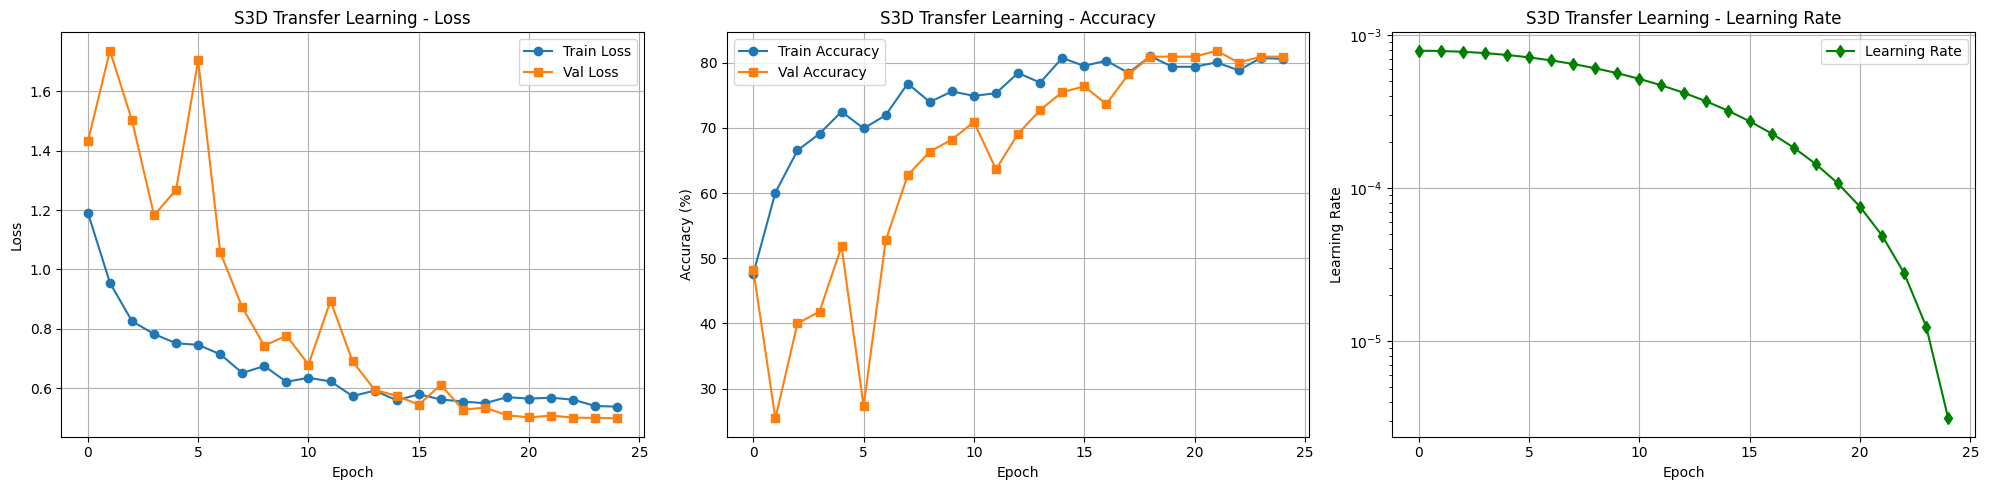


Final Validation Accuracy: 80.91%


In [ ]:
# Plot training history
def plot_history(history, title):
    # Check if learning rate is tracked
    has_lr = 'lr' in history and len(history['lr']) > 0
    
    if has_lr:
        fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    else:
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    axes[0].plot(history['train']['loss'], label='Train Loss', marker='o')
    axes[0].plot(history['val']['loss'], label='Val Loss', marker='s')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title(f'{title} - Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot accuracy
    axes[1].plot(history['train']['accuracy'], label='Train Accuracy', marker='o')
    axes[1].plot(history['val']['accuracy'], label='Val Accuracy', marker='s')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title(f'{title} - Accuracy')
    axes[1].legend()
    axes[1].grid(True)
    
    # Plot learning rate (if available)
    if has_lr:
        axes[2].plot(history['lr'], label='Learning Rate', marker='d', color='green')
        axes[2].set_xlabel('Epoch')
        axes[2].set_ylabel('Learning Rate')
        axes[2].set_title(f'{title} - Learning Rate')
        axes[2].set_yscale('log')  # Log scale for better visibility
        axes[2].legend()
        axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot transfer learning results
if 'history_transfer' in locals():
    plot_history(history_transfer, 'S3D Transfer Learning')
    print(f"\nFinal Validation Accuracy: {history_transfer['val']['accuracy'][-1]:.2f}%")


### Testing


In [ ]:
def predict_video(model, video_tensor, device, class_names):
    """
    Predict the class of a video.
    """
    model.eval()
    with torch.no_grad():
        video_tensor = video_tensor.unsqueeze(0).to(device)  # Add batch dimension
        output = model(video_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        confidence, predicted = probabilities.max(1)
        
    return class_names[predicted.item()], confidence.item()


# Test on TEST set
if 'model_transfer' in locals() and len(test_dataset) > 0:
    print("\n" + "="*50)
    print("Testing on TEST videos")
    print("="*50)
    
    test_loss, test_acc = validate(model_transfer, test_loader, criterion, device)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.2f}%")



Testing on TEST videos
Test Loss: 0.6350
Test Accuracy: 75.36%


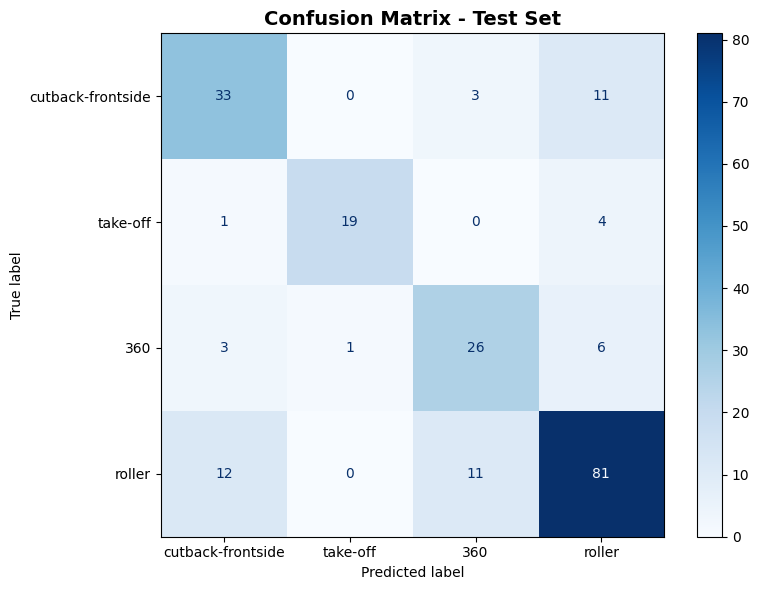


Per-class Accuracy:
  cutback-frontside: 70.21% (33/47)
  take-off: 79.17% (19/24)
  360: 72.22% (26/36)
  roller: 77.88% (81/104)


In [ ]:
# Confusion Matrix for Test Set
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

if 'model_transfer' in locals() and len(test_dataset) > 0:
    model_transfer.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for videos, labels in test_loader:
            videos = videos.to(device)
            outputs = model_transfer(videos)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print per-class accuracy
    print("\nPer-class Accuracy:")
    for i, class_name in enumerate(class_names):
        class_acc = cm[i, i] / cm[i].sum() * 100 if cm[i].sum() > 0 else 0
        print(f"  {class_name}: {class_acc:.2f}% ({cm[i, i]}/{cm[i].sum()})")


---

### References

- [S3D Paper: Rethinking Spatiotemporal Feature Learning](https://arxiv.org/abs/1712.04851)
- [PyTorch Video Models Documentation](https://pytorch.org/vision/stable/models.html#video-classification)
- [Kinetics-400 Dataset](https://deepmind.com/research/open-source/kinetics)
